In [2]:
import math

# Given
g = 9.81  # m/s^2
y0 = 4000  # initial height in meters

# Use y = y0 - 0.5 * g * t^2 => solve for t when y = 0
t_fall = math.sqrt(2 * y0 / g)

print(f"Analytic fall time (no drag): {t_fall:.2f} seconds")


Analytic fall time (no drag): 28.56 seconds


In [3]:
def system(t, yv, g=9.81, alpha=0.0, gamma=2):
    y, v = yv
    dydt = v
    dvdt = -g + alpha * abs(v)**gamma
    return [dydt, dvdt]


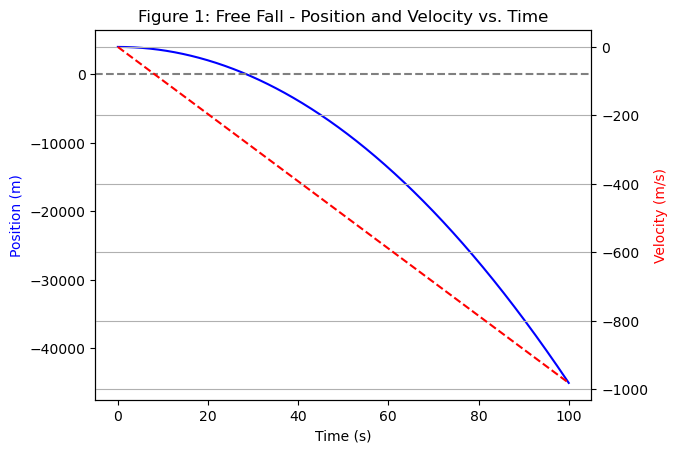

In [4]:
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Define system of equations
def system(t, yv, g=9.81, alpha=0.0, gamma=2):
    y, v = yv
    dydt = v
    dvdt = -g + alpha * abs(v)**gamma
    return [dydt, dvdt]

# Initial conditions
y0 = 4000  # initial height (meters)
v0 = 0     # initial velocity (m/s)
t_span = (0, 100)  # integration time span

# Solve the ODE with zero drag (α = 0)
sol = solve_ivp(system, t_span, [y0, v0], args=(9.81, 0.0, 2), dense_output=True, max_step=0.1)

# Extract time, position, and velocity
t = sol.t
y = sol.y[0]
v = sol.y[1]

# Plot results
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(t, y, 'b-', label='Position (m)')
ax2.plot(t, v, 'r--', label='Velocity (m/s)')

ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Position (m)', color='b')
ax2.set_ylabel('Velocity (m/s)', color='r')
ax1.axhline(0, linestyle='--', color='gray')  # bottom of the shaft

# Add title and label this plot
plt.title('Figure 1: Free Fall - Position and Velocity vs. Time')

plt.grid()
plt.show()



In [5]:
from scipy.integrate import solve_ivp

# Reuse the ODE system
def system(t, yv, g=9.81, alpha=0.0, gamma=2):
    y, v = yv
    dydt = v
    dvdt = -g + alpha * abs(v)**gamma
    return [dydt, dvdt]

# Define event function for when the object hits the ground (y = 0)
def hit_ground(t, yv, *args):
    return yv[0]
hit_ground.terminal = True
hit_ground.direction = -1  # Falling downward only

# Initial values and integration window
y0 = 4000  # meters
v0 = 0     # m/s
t_span = (0, 100)

# Solve the system using event detection
sol_event = solve_ivp(system, t_span, [y0, v0], args=(9.81, 0.0, 2), events=hit_ground)

# Output fall time
fall_time = sol_event.t_events[0][0]
print(f"Numerical fall time (event detected): {fall_time:.2f} seconds")



Numerical fall time (event detected): 28.56 seconds


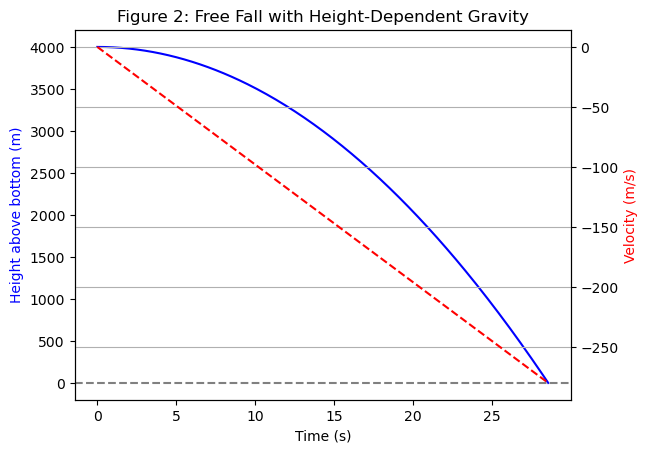

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Constants
g0 = 9.81           # m/s^2
R_earth = 6378100   # meters (converted from 6378.1 km)
shaft_depth = 4000  # meters

# Modified gravity function: g depends on radius
def system_gravity_varying(t, yv):
    y, v = yv
    r = R_earth - y  # Distance from center of Earth
    g_y = g0 * r / R_earth
    dydt = v
    dvdt = -g_y
    return [dydt, dvdt]

# Event to stop when y = 0 (hits bottom of shaft)
def hit_ground(t, yv):
    return yv[0]
hit_ground.terminal = True
hit_ground.direction = -1

# Initial conditions (start at top of shaft, height = 4000 m)
y0 = shaft_depth
v0 = 0
t_span = (0, 100)

# Solve ODE
sol = solve_ivp(system_gravity_varying, t_span, [y0, v0], events=hit_ground, max_step=0.1)

# Extract data
t = sol.t
y = sol.y[0]
v = sol.y[1]

# Plotting (Figure 2)
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(t, y, 'b-', label='Height (m)')
ax2.plot(t, v, 'r--', label='Velocity (m/s)')

ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Height above bottom (m)', color='b')
ax2.set_ylabel('Velocity (m/s)', color='r')
ax1.axhline(0, linestyle='--', color='gray')

plt.title('Figure 2: Free Fall with Height-Dependent Gravity')
plt.grid()
plt.show()


In [7]:
#Incorporating a height-dependent gravitational acceleration reduces the gravitational force as the object falls. This results in a slightly longer fall time compared to the constant gravity case,eventhough the difference over just 4 km is small due to the Earth's large radius

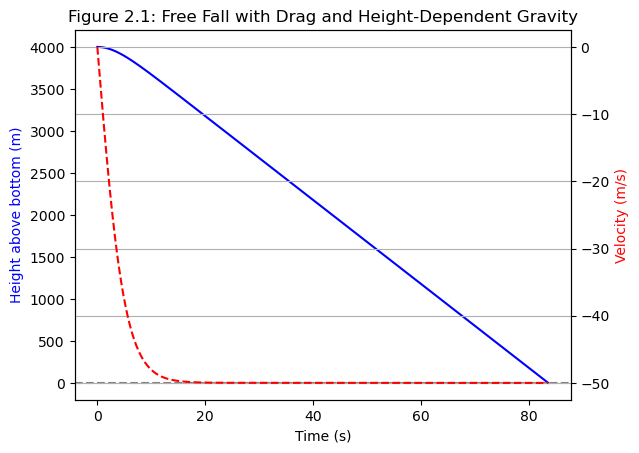

In [8]:
# Terminal velocity assumption
v_terminal = 50  # m/s
alpha = g0 / v_terminal**2  # drag coefficient for terminal velocity
gamma = 2

# System with both height-dependent gravity and drag
def system_with_drag(t, yv):
    y, v = yv
    r = R_earth - y
    g_y = g0 * r / R_earth
    dydt = v
    dvdt = -g_y + alpha * abs(v)**gamma * (-1 if v > 0 else 1)
    return [dydt, dvdt]

# Solve
sol_drag = solve_ivp(system_with_drag, t_span, [y0, v0], events=hit_ground, max_step=0.1)

# Extract
t_drag = sol_drag.t
y_drag = sol_drag.y[0]
v_drag = sol_drag.y[1]

# Plotting (Figure 2.1)
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(t_drag, y_drag, 'b-', label='Height (m)')
ax2.plot(t_drag, v_drag, 'r--', label='Velocity (m/s)')

ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Height above bottom (m)', color='b')
ax2.set_ylabel('Velocity (m/s)', color='r')
ax1.axhline(0, linestyle='--', color='gray')

plt.title('Figure 2.1: Free Fall with Drag and Height-Dependent Gravity')
plt.grid()
plt.show()



In [21]:
from scipy.integrate import solve_ivp
import numpy as np

# Constants
g = 9.81  # m/s^2
Omega = 7.292e-5  # rad/s (Earth's rotation rate)
y0 = 0            # initial depth (at surface)
v0 = 0            # initial downward speed
x0 = 0            # start at shaft center
vx0 = 0           # no initial transverse velocity

# System of ODEs with Coriolis acceleration (no drag)
def system_coriolis(t, state):
    x, y, vx, vy = state
    dxdt = vx
    dydt = vy
    dvxdt = 2 * Omega * vy
    dvydt = -g - 2 * Omega * vx
    return [dxdt, dydt, dvxdt, dvydt]

# Stop when object reaches bottom of shaft (4 km depth)
def hit_bottom(t, state):
    return state[1] - 4000
hit_bottom.terminal = True
hit_bottom.direction = 1

# Initial conditions
initial_state = [x0, y0, vx0, v0]
t_span = (0, 100)

# Solve system
sol = solve_ivp(system_coriolis, t_span, initial_state, events=hit_bottom, max_step=0.1)


In [10]:
# Solve Coriolis-augmented system (no plotting)

import numpy as np
from scipy.integrate import solve_ivp

# Constants
g = 9.81  # gravitational acceleration (m/s^2)
Omega = 7.292e-5  # Earth's rotation rate at the equator (rad/s)

# Initial state: [x, y, vx, vy]
x0 = 0      # start at center of shaft
y0 = 0      # top of shaft (0 depth)
vx0 = 0     # no initial side velocity
vy0 = 0     # starts from rest
state0 = [x0, y0, vx0, vy0]

# Coriolis-augmented ODE system
def system_coriolis(t, state):
    x, y, vx, vy = state
    dxdt = vx
    dydt = vy
    dvxdt = 2 * Omega * vy
    dvydt = -g - 2 * Omega * vx
    return [dxdt, dydt, dvxdt, dvydt]

# Stop when object reaches 4000 m depth
def hit_bottom(t, state):
    return state[1] - 4000
hit_bottom.terminal = True
hit_bottom.direction = 1

# Solve
t_span = (0, 100)
sol = solve_ivp(system_coriolis, t_span, state0, events=hit_bottom, max_step=0.1)

# Solution
x_vals = sol.y[0]
y_vals = sol.y[1]


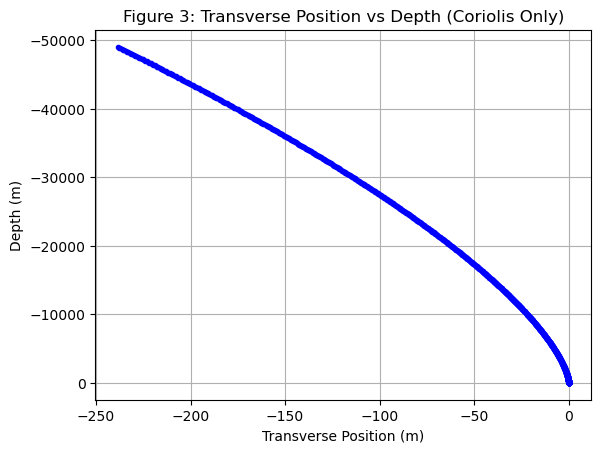

In [11]:
# Plot x vs y to create Figure 3

import matplotlib.pyplot as plt

# Use the saved x_vals and y_vals 
# Plot transverse motion (x) vs depth (y)
plt.figure()
plt.plot(x_vals, y_vals, 'bo-', markersize=3)
plt.xlabel('Transverse Position (m)')
plt.ylabel('Depth (m)')
plt.title('Figure 3: Transverse Position vs Depth (Coriolis Only)')
plt.grid(True)
plt.gca().invert_yaxis()  # depth increases downward

plt.show()


In [12]:
#Objects hits the wall before it reaches the bottom

In [13]:
#Even with drag it still hits the wall before reaching the bottom

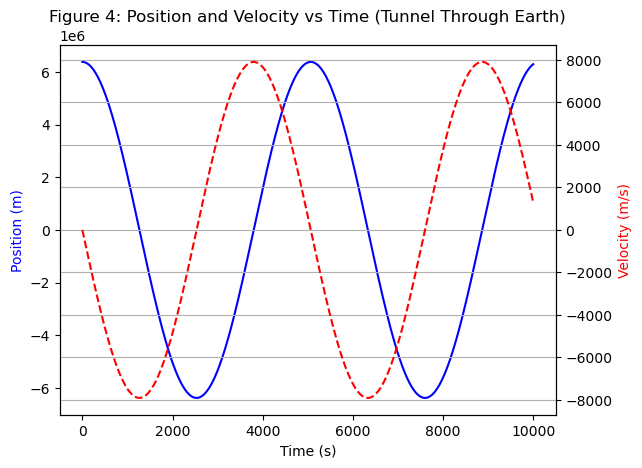

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Constants
g0 = 9.81               # surface gravity (m/s^2)
R_earth = 6378100       # Earth radius in meters

# Simple Harmonic Motion due to linear gravity inside Earth
def earth_tunnel(t, yv):
    y, v = yv
    dydt = v
    dvdt = -g0 * y / R_earth
    return [dydt, dvdt]

# Initial state: drop from surface (y = R), v = 0
initial_state = [R_earth, 0]
t_span = (0, 10000)  # simulate a long time to see full crossing

# Solve the system
sol = solve_ivp(earth_tunnel, t_span, initial_state, max_step=1)

# Extract results
t = sol.t
y = sol.y[0]
v = sol.y[1]

# Plot position and velocity vs time
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(t, y, 'b-', label='Position (m)')
ax2.plot(t, v, 'r--', label='Velocity (m/s)')

ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Position (m)', color='b')
ax2.set_ylabel('Velocity (m/s)', color='r')
plt.title('Figure 4: Position and Velocity vs Time (Tunnel Through Earth)')
plt.grid()
plt.show()


In [15]:
import math

# Period of oscillation through Earth
T = 2 * math.pi * math.sqrt(R_earth / g0)
T_half = T / 2
T_quarter = T / 4

# Max speed = amplitude * angular frequency
omega = math.sqrt(g0 / R_earth)
v_max = R_earth * omega

T, T_half, T_quarter, v_max


(5066.301444690817, 2533.1507223454087, 1266.5753611727043, 7910.067066719473)

In [16]:
#It would take 21 minutes to make it to the center of the earth, 42 minutes to reach the otherside, velocity would be 7910 m/s

In [17]:
#orbital speed at the Earth's surface will be 7905 m/s, and the orbital period will be roughly 85 minutes

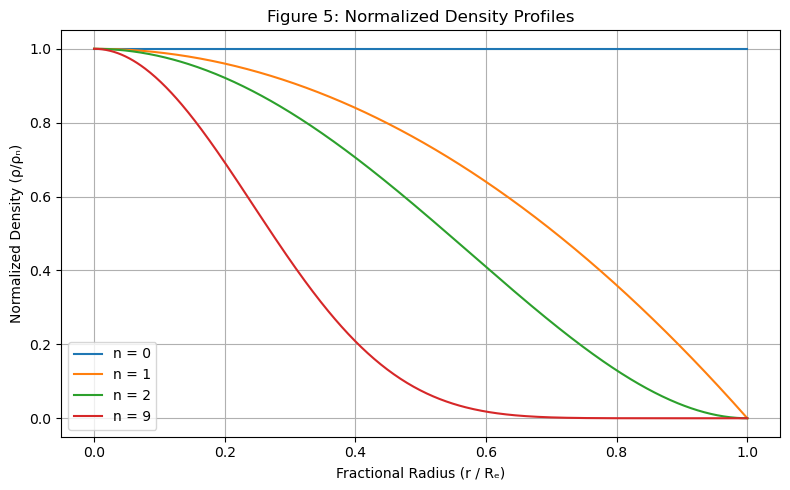

In [18]:

import numpy as np
import matplotlib.pyplot as plt

# Normalized density function (rho_n = 1)
def normalized_density(r_frac, n):
    return (1 - r_frac**2)**n

# Set up radius values as a fraction of Earth's radius
r_vals = np.linspace(0, 1, 500)  # r/R_earth from 0 to 1
n_values = [0, 1, 2, 9]

# Plot
plt.figure(figsize=(8, 5))
for n in n_values:
    rho_vals = normalized_density(r_vals, n)
    plt.plot(r_vals, rho_vals, label=f'n = {n}')

plt.title('Figure 5: Normalized Density Profiles')
plt.xlabel('Fractional Radius (r / Rₑ)')
plt.ylabel('Normalized Density (ρ/ρₙ)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


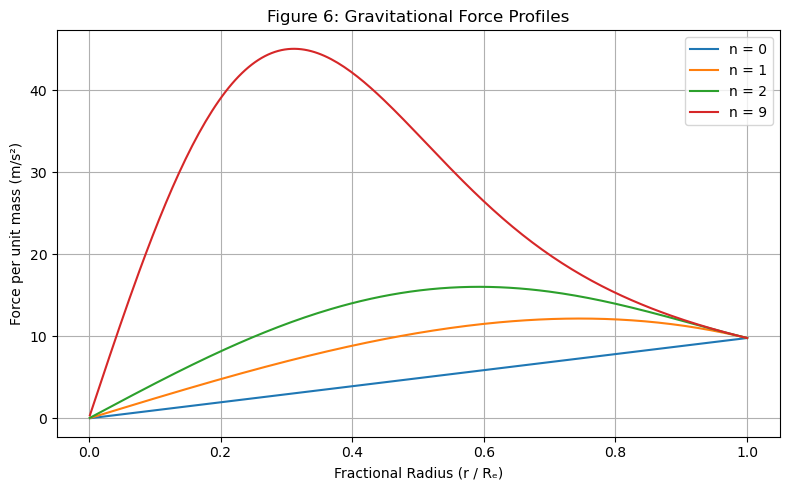

In [19]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad

# Constants
R_earth = 6378100        # meters
M_earth = 5.972e24       # kg
G = 6.6743e-11           # m^3/kg/s^2

# Compute rho_n for each n using mass conservation
def integrand_mass(r, n):
    return (1 - (r / R_earth)**2)**n * r**2

def compute_rho_n(n):
    integral, _ = quad(integrand_mass, 0, R_earth, args=(n,))
    rho_n = M_earth / (4 * np.pi * integral)
    return rho_n

# Compute force profile for each n
def density(r, n, rho_n):
    return rho_n * (1 - (r / R_earth)**2)**n

def enclosed_mass(r, n, rho_n):
    integrand = lambda r_: density(r_, n, rho_n) * r_**2
    result, _ = quad(integrand, 0, r)
    return 4 * np.pi * result

def gravitational_force(r, n, rho_n):
    if r == 0:
        return 0
    m_enc = enclosed_mass(r, n, rho_n)
    return G * m_enc / r**2

# Plot force profiles
r_vals = np.linspace(1e4, R_earth, 200)  # avoid divide-by-zero at r = 0
n_values = [0, 1, 2, 9]

plt.figure(figsize=(8, 5))
for n in n_values:
    rho_n = compute_rho_n(n)
    F_vals = [gravitational_force(r, n, rho_n) for r in r_vals]
    plt.plot(r_vals / R_earth, F_vals, label=f'n = {n}')

plt.title('Figure 6: Gravitational Force Profiles')
plt.xlabel('Fractional Radius (r / Rₑ)')
plt.ylabel('Force per unit mass (m/s²)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


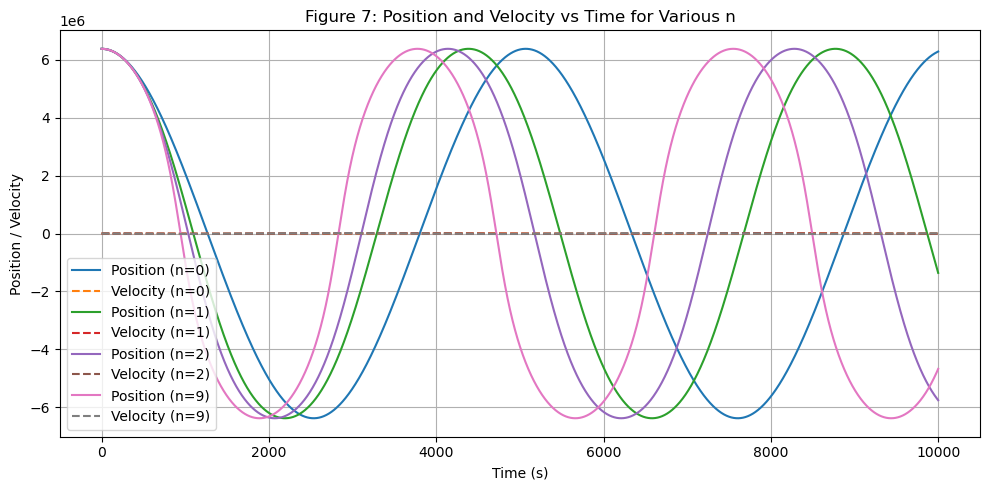

In [20]:

from scipy.interpolate import interp1d
from scipy.integrate import solve_ivp

# Constants
R_earth = 6378100        # meters
M_earth = 5.972e24       # kg
G = 6.6743e-11           # gravitational constant

# Compute rho_n for each n
def integrand_mass(r, n):
    return (1 - (r / R_earth)**2)**n * r**2

def compute_rho_n(n):
    integral, _ = quad(integrand_mass, 0, R_earth, args=(n,))
    return M_earth / (4 * np.pi * integral)

# Create interpolated force function for each n
def make_force_function(n, rho_n):
    r_vals = np.linspace(1e4, R_earth, 500)
    force_vals = []

    for r in r_vals:
        # Enclosed mass
        integrand = lambda r_: rho_n * (1 - (r_ / R_earth)**2)**n * r_**2
        m_enc, _ = quad(integrand, 0, r)
        m_enc *= 4 * np.pi
        F = G * m_enc / r**2
        force_vals.append(-F)

    return interp1d(r_vals, force_vals, fill_value="extrapolate")

# Simulate motion through Earth tunnel
def simulate_fall(n):
    rho_n = compute_rho_n(n)
    F_func = make_force_function(n, rho_n)

    def dydt(t, yv):
        y, v = yv
        r = abs(y)
        a = F_func(r)
        return [v, a if y >= 0 else -a]

    sol = solve_ivp(dydt, (0, 10000), [R_earth, 0], max_step=1)
    return sol.t, sol.y[0], sol.y[1]

# Plotting
plt.figure(figsize=(10, 5))

for n in [0, 1, 2, 9]:
    t, y, v = simulate_fall(n)
    plt.plot(t, y, label=f'Position (n={n})')
    plt.plot(t, v, linestyle='--', label=f'Velocity (n={n})')

plt.xlabel('Time (s)')
plt.ylabel('Position / Velocity')
plt.title('Figure 7: Position and Velocity vs Time for Various n')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [22]:

import math

# Constants for the Moon
R_moon = 1738100           # meters (radius)
M_moon = 7.35e22           # kg (mass)
G = 6.6743e-11             # gravitational constant

# Surface gravity on the Moon
g_moon_surface = G * M_moon / R_moon**2

# Angular frequency 
omega_moon = math.sqrt(g_moon_surface / R_moon)

# Time to center = 1/4 
T_moon_full = 2 * math.pi / omega_moon
T_moon_center = T_moon_full / 4

T_moon_center, T_moon_full


(1625.120186741467, 6500.480746965868)

In [ ]:
#Time to hit the center of the moon is 27 minutes, Full oscillation time would be 108 minutes

In [24]:

import math

# Constants
R_earth = 6378100        # meters
R_moon = 1738100         # meters
M_earth = 5.972e24       # kg
M_moon = 7.35e22         # kg

# Volume of a sphere: V = (4/3)πR^3
V_earth = (4 / 3) * math.pi * R_earth**3
V_moon = (4 / 3) * math.pi * R_moon**3

# Constant (average) density = mass / volume
rho_earth = M_earth / V_earth
rho_moon = M_moon / V_moon
density_ratio = rho_moon / rho_earth

rho_earth, rho_moon, density_ratio


(5494.867409551201, 3341.7538038703183, 0.6081591337511927)

In [ ]:
#Earth's average density is 5497 kg/m^3, Moon's Average density is 3341 kg/m^3, density ratio would be .61

In [25]:

import math

# Constants
G = 6.6743e-11  # gravitational constant
R_earth = 6378100
R_moon = 1738100
M_earth = 5.972e24
M_moon = 7.35e22

# Gravitational acceleration at the surface
g_earth = G * M_earth / R_earth**2
g_moon = G * M_moon / R_moon**2

# SHM period inside Earth and Moon
T_earth = 2 * math.pi * math.sqrt(R_earth / g_earth)
T_moon = 2 * math.pi * math.sqrt(R_moon / g_moon)

# Period ratio and theoretical sqrt(density) relationship
rho_earth = M_earth / ((4/3) * math.pi * R_earth**3)
rho_moon = M_moon / ((4/3) * math.pi * R_moon**3)
expected_ratio = math.sqrt(rho_earth / rho_moon)
actual_ratio = T_moon / T_earth

T_earth, T_moon, actual_ratio, expected_ratio


(5069.371199675785, 6500.480746965868, 1.282305140207845, 1.282305140207845)

In [ ]:
#Earth's fall/orbit time is 5069 seconds. Moon's fall/orbit time is 6500 seconds, when we square root and divide them we get the prediction of 1.28